In [8]:
import pandas as pd 
import os 
import numpy as np

In [5]:
processed = pd.read_csv('Data/processed_tweets.csv')

/Users/noah/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,32,33,34,35,38,39,40,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
data = pd.read_csv("Data/processed_tweets.csv", index_col = False)
data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148239 entries, 0 to 1148238
Data columns (total 97 columns):
user_id                    1148239 non-null object
status_id                  1148239 non-null object
created_at                 1148239 non-null object
screen_name                1148239 non-null object
text                       1148239 non-null object
source                     1148239 non-null object
display_text_width         1148239 non-null int64
reply_to_status_id         112384 non-null object
reply_to_user_id           118204 non-null object
reply_to_screen_name       118204 non-null object
is_quote                   1148239 non-null bool
is_retweet                 1148239 non-null bool
favorite_count             1148239 non-null int64
retweet_count              1148239 non-null int64
quote_count                0 non-null float64
reply_count                0 non-null float64
hashtags                   467286 non-null object
symbols                    45 non-null ob

In [9]:
#Loading gloVe Word Embeddings

embeddings_dict = {}
with open("Data/glove.twitter.27B/glove.twitter.27B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
num_classes = 5
# One hot encoding target
def onehot(arr, num_class):
    return np.eye(num_class)[np.array(arr.astype(int)).reshape(-1)]

y = onehot(processed["group"], num_classes)

In [45]:
def points_to_class(points):
    if points ==1 :
        return 0
    elif points == 2:
        return 1
    elif points == 3:
        return 2
    elif points == 4:
        return 3
    else:
        return 4
    
data["pol_rating"] = data["group"].apply(points_to_class)

In [47]:
np.unique(data['pol_rating'])

array([0, 1, 2, 3, 4])

In [49]:
np.eye(5)[np.array(data["pol_rating"].astype(int)).reshape(-1)]

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [50]:
def onehot(arr, num_class):
    return np.eye(num_class)[np.array(arr.astype(int)).reshape(-1)]

y = onehot(data["pol_rating"], num_classes)

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data["text"], y, test_size = 0.05)

In [68]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize



stopwords = set(stopwords.words('english'))

detokenizer = TreebankWordDetokenizer()

def clean_description(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)

data["cleaned_text"] = data["text"].apply(clean_description)

In [71]:
#Model
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, Input, Activation, CuDNNGRU, Bidirectional, Dropout, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

#parameters
num_classes = 5
dims = 50 
epochs = 50
batch_size = 128
max_len = 220

tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(X_train)


sequences_train = tokenizer.texts_to_sequences(X_train)


X_train = pad_sequences(sequences_train, maxlen=max_len)

sequences_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(sequences_val, maxlen = max_len)

word_index = tokenizer.word_index
                

embedding_matrix = np.zeros((len(word_index) + 1, dims))
        
for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [74]:
class_weights = {0: 1,
                1: 1,
                2: 1, 
                3: 1,
                4: 1}

In [75]:
#Fit
from keras.layers import GRU
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False) 
input= Input(shape=(max_len, ), dtype = 'int32')
embedded_sequences = embedding_layer(input) 
x = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation = 'relu')(x)
x = Dropout(0.1)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input, outputs=output)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        
checkpoint = ModelCheckpoint("modelOne", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
callback = [checkpoint, early]
        
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=callback, class_weight = class_weights)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1090827 samples, validate on 57412 samples
Epoch 1/50
1090827/1090827 [==============================] - 3206s 3ms/step - loss: 1.4721 - accuracy: 0.3320 - val_loss: 1.4248 - val_accuracy: 0.3557

Epoch 00001: val_loss improved from inf to 1.42484, saving model to model.h5
Epoch 2/50
1090827/1090827 [==============================] - 3233s 3ms/step - loss: 1.4143 - accuracy: 0.3648 - val_loss: 1.4030 - val_accuracy: 0.3709

Epoch 00002: val_loss improved from 1.42484 to 1.40300, saving model to model.h5
Epoch 3/50
1090827/1090827 [==============================] - 3223s 3ms/step - loss: 1.3912 - accuracy: 0.3773 - val_loss: 1.3836 - val_accuracy: 0.3820

Epoch 00003: val_loss improved from 1.40300 to 1.38363, saving model to model.h5
Epoch 4/50
1090827/1090827 [==============================] - 3326s 3ms/step - loss: 1.3758 - accuracy: 0.3852 - val_loss

In [77]:
from sklearn.metrics import accuracy_score

test = data

sequences_test = tokenizer.texts_to_sequences(test["text"])
X_test = pad_sequences(sequences_test, maxlen=max_len)

# Predictions
pred_test = model.predict(X_test)
pred_test = [np.argmax(x) for x in pred_test]



NameError: name 'num_class' is not defined

In [78]:

true_test = onehot(test["pol_rating"], 5)
true_test = [np.argmax(x) for x in true_test]


accuracy = accuracy_score(true_test, pred_test)

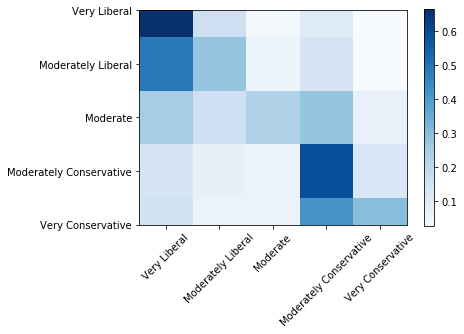

In [87]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(true_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

class_name = ["Very Liberal", "Moderately Liberal", "Moderate", "Moderately Conservative", "Very Conservative"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)

plt.show()

In [83]:
accuracy

0.42466507408300885

In [88]:
cm

array([[0.66668496, 0.16227752, 0.03863415, 0.10505336, 0.02735001],
       [0.48673485, 0.28025794, 0.06173995, 0.1402975 , 0.03096976],
       [0.25027999, 0.16052945, 0.2313174 , 0.28200473, 0.07586842],
       [0.13604564, 0.07891284, 0.0682366 , 0.59019898, 0.12660594],
       [0.1474032 , 0.06894293, 0.06468999, 0.41887381, 0.30009007]])

In [101]:
#Model 2
model2_data = data = pd.read_csv("Data/processed_tweets.csv", index_col = False)


In [96]:
print('Training Dimensions: '+ str(train2.shape))
print('Testing Dimensions: '+ str(test2.shape))

Training Dimensions: (918591, 97)
Testing Dimensions: (229648, 97)


In [102]:
def points_to_class(group):
    if group < 2  :
        return 0
    elif group == 2:
        return 1
    else:
        return 2
    
model2_data["newgroup"] = model2_data["group"].apply(points_to_class)
model2_data["cleaned_text"] = model2_data["text"].apply(clean_description)
train2, test2 = train_test_split(model2_data, test_size=0.2)

In [103]:
num_classes = 3
y = onehot(train2["newgroup"], num_classes)

In [104]:
num_classes = 3
dims = 50 
epochs = 50
batch_size = 128
max_len = 220
X_train, X_val, y_train, y_val = train_test_split(train2["text"], y, test_size = 0.05)
tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)


X_train = pad_sequences(sequences_train, maxlen=max_len)

sequences_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(sequences_val, maxlen = max_len)

word_index = tokenizer.word_index
                

embedding_matrix = np.zeros((len(word_index) + 1, dims))
        
for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [105]:
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False) 
input= Input(shape=(max_len, ), dtype = 'int32')
embedded_sequences = embedding_layer(input) 
x = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation = 'relu')(x)
x = Dropout(0.1)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input, outputs=output)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        
checkpoint = ModelCheckpoint("modelTwo", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
callback = [checkpoint, early]
        
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=callback, class_weight = class_weights)

Train on 872661 samples, validate on 45930 samples
Epoch 1/50
872661/872661 [==============================] - 2604s 3ms/step - loss: 0.8665 - accuracy: 0.6165 - val_loss: 0.8460 - val_accuracy: 0.6218

Epoch 00001: val_loss improved from inf to 0.84605, saving model to model.h5
Epoch 2/50
872661/872661 [==============================] - 2645s 3ms/step - loss: 0.8252 - accuracy: 0.6345 - val_loss: 0.8255 - val_accuracy: 0.6337

Epoch 00002: val_loss improved from 0.84605 to 0.82545, saving model to model.h5
Epoch 3/50
872661/872661 [==============================] - 2682s 3ms/step - loss: 0.8086 - accuracy: 0.6416 - val_loss: 0.8116 - val_accuracy: 0.6407

Epoch 00003: val_loss improved from 0.82545 to 0.81156, saving model to model.h5
Epoch 4/50
872661/872661 [==============================] - 2696s 3ms/step - loss: 0.7978 - accuracy: 0.6467 - val_loss: 0.8078 - val_accuracy: 0.6433

Epoch 00004: val_loss improved from 0.81156 to 0.80783, saving model to model.h5
Epoch 5/50
872661/872

In [107]:
from sklearn.metrics import accuracy_score


sequences_test = tokenizer.texts_to_sequences(test2["text"])
X_test = pad_sequences(sequences_test, maxlen=max_len)

# Predictions
pred_test = model.predict(X_test)
pred_test = [np.argmax(x) for x in pred_test]
# Actual
true_test = onehot(test2["newgroup"],3)
true_test = [np.argmax(x) for x in true_test]

# Find accuracies
accuracy = accuracy_score(true_test, pred_test)

In [108]:
# Actual
true_test = onehot(test2["newgroup"], 5)
true_test = [np.argmax(x) for x in true_test]

# Find accuracies
accuracy = accuracy_score(true_test, pred_test)

In [109]:
accuracy

0.6566135999442625

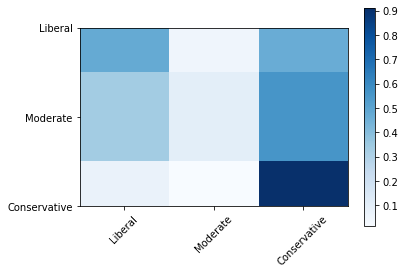

In [110]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(true_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

class_name = ["Liberal", "Moderate", "Conservative"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)

plt.show()